In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%%capture
!pip install --upgrade tqdm
!pip install parameter-sherpa

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sherpa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm

torch.__version__

'1.3.1'

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [0]:
path = "drive/My Drive/AML/"
#path = ""

df = pd.read_csv(path + "pmsm_temperature_data.csv")

In [6]:
df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


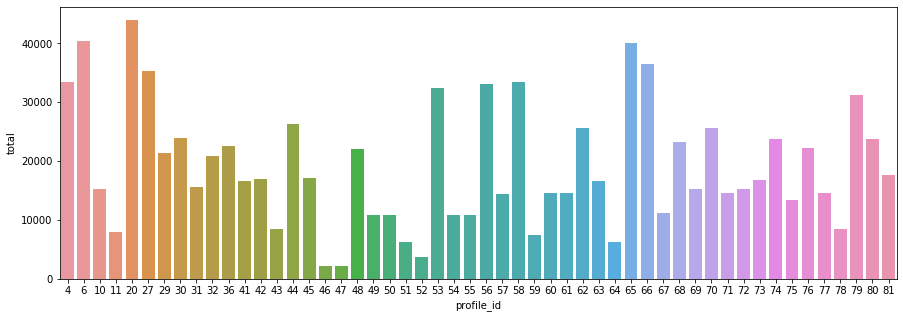

In [7]:
plt.figure(figsize=(15,5))
count = pd.DataFrame(df[['profile_id']].groupby('profile_id').size()).reset_index()
count.columns = ["profile_id", "total"]
sns.barplot(count.profile_id,count.total)
plt.show()

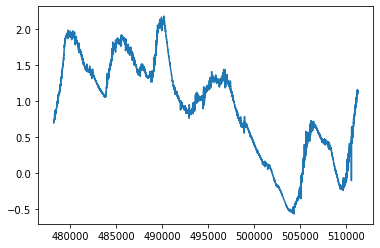

In [8]:
plt.plot(df[df.profile_id==56].pm)
plt.show()

In [0]:
df_sep = [df[df.profile_id==profile].drop(['profile_id','torque'], axis=1).reset_index(drop=True) for profile in df.profile_id.unique()]

In [10]:
df_sep[16]

,ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,-0.595910,2.171364,-1.589776,-0.587723,1.103304,-1.878195,0.680967,1.017145,1.882656,1.437981,1.053870
1,-0.621160,2.170850,-1.571330,-0.500914,1.099682,-1.804746,0.671327,1.021259,1.882521,1.439262,1.065586
2,-0.631429,2.170527,-1.557825,-0.424030,1.096316,-1.742421,0.663120,1.022086,1.882713,1.442306,1.080192
3,-0.626384,2.170454,-1.562527,-0.442516,1.098146,-1.757560,0.664252,1.024800,1.882829,1.446316,1.095144
4,-0.618749,2.170683,-1.576954,-0.534982,1.111325,-1.832702,0.667031,1.029729,1.883059,1.449144,1.108085
...,...,...,...,...,...,...,...,...,...,...,...
2174,-0.463984,2.172318,0.507567,0.353152,-0.347175,1.005747,-0.489718,1.804289,2.280776,1.991620,1.560164
2175,-0.460619,2.172481,0.507999,0.353206,-0.347188,1.005798,-0.490083,1.803187,2.280447,1.991620,1.556740
2176,-0.456195,2.172659,0.508290,0.353097,-0.347194,1.005808,-0.490337,1.801625,2.279769,1.991620,1.554234
2177,-0.453024,2.172829,0.508741,0.353127,-0.347196,1.005798,-0.490511,1.799392,2.279384,1.991620,1.551217


In [0]:
class GRU_Net(nn.Module):
    def __init__(self, features, hidden, h1, h2, out):
        super(GRU_Net, self).__init__()
        self.hidden_size = hidden
        self.features = features
        self.gru = nn.GRU(self.features, self.hidden_size, 1, #feature_size, hidden_size, num_layer
                            batch_first = True) 
        self.fc1 = nn.Linear(self.hidden_size, 
                                h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out)
        #self.hidden = None #torch.randn(1, ??, self.hidden) #num_layer, batch, hidden_size

    def forward(self, x):
        batch_size, _, _ = x.shape 

        #if self.hidden is not None:
        #    x, self.hidden =  self.gru(x, self.hidden)
        #else:
        #    x, self.hidden =  self.gru(x)
        
        x, _ =  self.gru(x)
        x = x[:,-1].view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

In [0]:
def sliding_window(dataset, target_var, inp, out):
    while True:
        for j, X in enumerate(dataset):
            if j==49 or j==50 or j==51: #it's validation time
                pass

            target = X[[target_var]]
            num_features = len(X.columns)

            for i in range(X.shape[0]):
                if i > inp + out - 1:
                    features = X.iloc[i-inp-out:i-out,].values.reshape(inp,num_features)
                    pred = target.iloc[i]

                    yield np.array(features), np.array(pred)

In [0]:
parameters = [sherpa.Discrete('gru_hidden',[20,100]),
              sherpa.Discrete('hidden_unit1',[16,64]),
              sherpa.Discrete('hidden_unit2',[16,64]),
              sherpa.Continuous('lr', [0.0005, 0.005]),
              sherpa.Ordinal(name='batch_size', range=[256, 512, 1024, 2048])]

alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [0]:
best_score = 99999

for trial in study:

    gru = GRU_Net(features=11, hidden=int(trial.parameters["gru_hidden"]), 
                  h1=int(trial.parameters["hidden_unit1"]), 
                  h2=int(trial.parameters["hidden_unit2"]), out=1).to(device)

    criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
    optimizer = torch.optim.Adam(gru.parameters(),lr=trial.parameters["lr"])

    batch_size = int(trial.parameters["batch_size"])

    df_length = np.sum([x.shape[0] for x in df_sep]) - df_sep[51].shape[0]

    gen = sliding_window(df_sep, "pm", 300, 1)
    progress_bar = tqdm(range(0, df_length, batch_size))

    gru.train()
    for b in progress_bar:
        X_train = []
        y_train = []
        for i in range(batch_size):
            try:
                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
            except StopIteration:
                #in case the datagen ends, recreate a new a one and continue
                #it should not happen though since the the datagen
                #should be infinite (theorically), it's more of a precaution
                gen = sliding_window(df_sep, "pm", 300, 1)

                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)

        inpt = np.array(X_train).reshape(-1, 300, 11)
        target = np.array(y_train)    
        x_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_batch = torch.tensor(target,dtype=torch.float32).to(device)
        try:
            output = gru(x_batch) 
            loss = criterion(output.view(-1), y_batch.view(-1))  

            loss.backward(retain_graph=True)
            optimizer.step()        
            optimizer.zero_grad()
        except:
            print("something strange happened")
            print(inpt.shape)
            print(x_batch.size())
            break
            
        progress_bar.set_description("Epoch:"+str(int(b/batch_size)+1)+" Loss:"+str(round(loss.item(),3)))
        
    test_gen = sliding_window([df_sep[49], df_sep[50], df_sep[51]], "pm", 300, 1)
    batch_size = 510

    gru.eval()
    y_test = []
    y_pred_all = []

    tot_len = df_sep[49].shape[0] + df_sep[50].shape[0] + df_sep[51].shape[0]
    for x in range(0, tot_len, batch_size):
        X_test = []
        for i in range(batch_size):
            try:
                X,y = next(test_gen)
                X_test.append(X)
                y_test.append(y)
            except:
                print("You created an exception hahaha!")
                break

        inpt = np.array(X_test).reshape(-1, 300, 11)
        x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_pred = gru(x_test_batch)

        y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

    y_test = np.array(y_test).reshape(-1)
    score = np.mean((y_test - y_pred_all)**2) #MSE
    if score < best_score:
        best_score = score
        torch.save(gru, path + "best_model_lstm")
    
    #Sherpa PART
    study.add_observation(trial, iteration=1, objective=score)
    study.finalize(trial)
    study.results.to_csv(path + "AutoML_LSTM.csv")

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


In [0]:
test_gen = sliding_window([df_sep[51]], "pm", 300, 1)
batch_size = 510

y_test = []
y_pred_all = []
for x in range(0, df_sep[51].shape[0], batch_size):
    X_test = []
    for i in range(batch_size):
        try:
            X,y = next(test_gen)
            X_test.append(X)
            y_test.append(y)
        except:
            break

    inpt = np.array(X_test).reshape(-1, 300, 11)
    x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
    y_pred = gru(x_test_batch)

    y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

In [0]:
y_test = np.array(y_test).reshape(-1)
plt.figure(figsize=(10,10))
plt.plot(y_test)
plt.plot(y_pred_all)

plt.show()

In [0]:
np.mean(np.abs(y_test - y_pred_all)/y_test)